# BEAT-PD Challenge

Challenge website : https://www.synapse.org/#!Synapse:syn20825169/wiki/596118

Data information : https://www.synapse.org/#!Synapse:syn20825169/wiki/600405


### Ideas/Doubts [Laureano]

VAD like thing to remove unwanted data?
modified MFCC?
X,Y,Z = relative positions or acceleration?

Imp: Predict per person. Maybe UBM like thing and adapt it

In [9]:
# Import required libraries

import pandas as pd
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt

# Import required modules
from sklearn.preprocessing import StandardScaler

In [2]:
# Data paths

data_dir='/home/sjoshi/codes/python/BeatPD/data/BeatPD/'
path_save_accelerometer_plots='/home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/'

In [3]:
def define_data_type(data_type):
    # Setup file names

    '''
    data_type={cis , real}

    If data_type is real, data_real_subtype 
    data_real_subtype={smartphone_accelerometer , smartwatch_accelerometer , smartwatch_gyroscope}
    '''
    if data_type=='cis':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'

    if data_type=='real':
        path_train_labels=data_dir+data_type+'-pd.data_labels/'+data_type.upper()+'-PD_Training_Data_IDs_Labels.csv'
        path_train_data=data_dir+data_type+'-pd.training_data/'+data_real_subtype+'/'

    # Display labels
    df_train_label=pd.read_csv(path_train_labels)
    return path_train_data, df_train_label

In [4]:
def plot_accelerometer(data_type, path_accelerometer_plots, display_df_train_data=False):
    # Iterating through all the indexes contained in df_train_label
    for idx in df_train_label.index: 
        df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
        # BUG ?  why this goes to 1000xxx sometimes? 
        display(df_train_data)
        # Prints the t x y z table if we want to see it
        #print(display(df_train_data) if display_df_train_data else '')

        # Following val_* variables are only used to format a cute title for the plots
        val_subject_id = df_train_label.loc[[idx]]['subject_id'].values[0]
        val_on_off = df_train_label.loc[[idx]]['on_off'].values[0]
        val_dyskinesia = df_train_label.loc[[idx]]['dyskinesia'].values[0]
        val_tremor = df_train_label.loc[[idx]]['tremor'].values[0]
        great_title = "{0} = on_off: {1}, dyskinesia: {2}, tremor: {3}".format(val_subject_id, val_on_off, val_dyskinesia, val_tremor)

        # The time doesn't have the same name depending on the data_type
        x_axis_data_type = 't' if data_type == 'real' else 'Timestamp'
        
        # Normalize the data
        #df_train_data[['x','y','z']] = StandardScaler().fit_transform(df_train_data[['x','y','z']])
        cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
        df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

        
        df_train_data.plot(x=x_axis_data_type,legend=True, subplots=True,title=great_title)
        #plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        # Save plot with the measurement_id as name of the file
        plt.savefig(path_accelerometer_plots+df_train_label["measurement_id"][idx]+'.png')
        plt.show()

In [5]:
def prepro_missing_values(df_train_label):
    # Replace NaN values with -1.0 because otherwise plotting triggers an error 
    df_train_label = df_train_label.fillna(value=-1.0)
    return df_train_label

def compute_symptoms_occurences_dataframe(df_train_label):
    df_train_label = prepro_missing_values(df_train_label=df_train_label)
    
    # Group data by subject_id 
    df_train_label_subject_id = df_train_label.groupby('subject_id')

    df_occurences = []
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    
    for key, value in df_train_label_subject_id :
        for symptom in symptoms:
            # Pour un patient, prendre les 3 dernieres colonnes, et pour 1 symptome, calculer le nb d'occurences
            counter = df_train_label_subject_id.get_group(key).iloc[:,-3:][symptom].value_counts()

            for symptom_value, symptom_occurence in counter.items():
                df_occurences.append(({'subject_id': key, 'symptom': symptom, 'symptom_value': symptom_value, 'occurence': symptom_occurence}))

    df_occurences = pd.DataFrame(df_occurences, columns=('subject_id', 'symptom', 'symptom_value', 'occurence'))

    # Change the default option to display all row with display(DF)
    # pd.set_option('display.max_rows', 1000)
    
    print('display df occurences')
    display(df_occurences)
    return df_occurences, df_train_label_subject_id


In [6]:
'''
This function plots the occurences of symptoms according to subject_id 

Arguments: 
- df_occurences: contains the df with occurences computed in compute_symptoms_occurences_dataframe
- df_train_label_subject_id: contains df_train_label grouped by subject_id 
'''
def plot_symptoms_occurences(df_occurences, df_train_label_subject_id):
    
    # There will be one graph plotted for each patient, for each of the 3 symptoms
    nb_subjects_id = df_occurences.subject_id.nunique() # nb of unique patients in the label file
    print("Nb subject_id : ", nb_subjects_id)
    height = 30 if nb_subjects_id > 10 else 10
    fig, axes = plt.subplots(nrows=nb_subjects_id, ncols=3, figsize=(10,height), sharey=True) # 3 cols for the 3 symptoms
    
    # Quick fix to plot the graphs at the right place. Starts at -1 because in the first for loop 
    # it is incremented
    patient = -1

    #Plot for all subject_id 3 bar plots for all the symptoms and their occurences
    # Reminder that NaN values (missing values) were replaced with -1 and are shown as such in the plots
    symptoms = ['on_off', 'dyskinesia', 'tremor']
    for key, value in df_train_label_subject_id :
        patient = patient + 1 # value used to position the plots (row)
        symptom_no = 0 # value only used to position the plots (col)
        for symptom in symptoms:
            subject_symptom = ' '.join([str(key), symptom]) # variable used to create a title for each plot
            df_train_label_subject_id.get_group(key)[symptom].value_counts().plot(kind='bar',
                                                                                  x=symptom,
                                                                                  title=subject_symptom, 
                                                                                  ax=axes[patient,symptom_no],
                                                                                  sharey=True)
                                                                                  
            fig.tight_layout()
            plt.tight_layout()
            symptom_no = symptom_no + 1
    #plt.close(fig)

In [7]:
'''
Filters df_train_label according to a list of measurement_id we are interested in analyzing

Arguments:
- df_train_label: dataframe with labels
- list_measure_id: list of measurement_id 

Returns:
- df_train_label: filtered df_train_label containing only the measurements_id we are interested in 
'''
def interesting_patients(df_train_label, list_measurement_id):
    filter_measurement_id = df_train_label.measurement_id.isin(list_measurement_id)

    df_train_label = df_train_label[filter_measurement_id]
    display(df_train_label)
    return df_train_label

possible to have participant characteristics from additional db data? ex https://ieeexplore.ieee.org/abstract/document/7911257

# CIS-PD Database

Contains 16 subject_id (patients) for the training set 

- Gender: 11 Male, 5 Female 
- Race: 15 White, 1 NA
- Ethnicity: 15 Not Hispanic or Latino, 1 Unknown
- Age average (standard deviation) : 62.8125 (10.8579)

,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


,measurement_id,subject_id,on_off,dyskinesia,tremor
668,db2e053a-0fb8-4206-891a-6f079fb14e3a,1023,4.0,1.0,0.0


,Timestamp,X,Y,Z
0,0.000,0.968506,0.188232,0.181152
1,0.020,0.966553,0.187744,0.178223
2,0.040,0.968018,0.186768,0.177734
3,0.060,0.968018,0.188721,0.176270
4,0.080,0.967529,0.189209,0.178711
5,0.100,0.968994,0.188721,0.179199
6,0.120,0.966064,0.187256,0.179688
7,0.140,0.967529,0.190186,0.178711
8,0.160,0.968018,0.187256,0.179199
9,0.180,0.968506,0.188232,0.179199


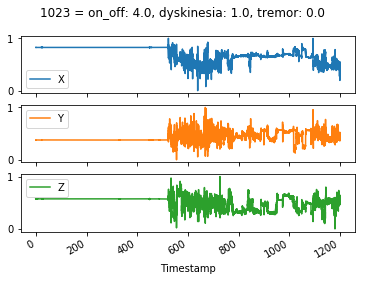

In [11]:
data_type='cis'

# TODO: explain
path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=[#'ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
'db2e053a-0fb8-4206-891a-6f079fb14e3a']#,
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
display(df_train_label)

# Plot the accelerometer data 
plot_accelerometer(data_type=data_type, display_df_train_data=True, path_accelerometer_plots=path_save_accelerometer_plots)


## WIP : Function to remove silence

In [56]:
# def remove_silence():
# for idx in df_train_label.index: 
#     df_train_data=pd.read_csv(path_train_data+df_train_label["measurement_id"][idx]+'.csv')
#     cols_to_norm = ['x','y','z'] if data_type == 'real' else ['X','Y','Z']
#     df_train_data[cols_to_norm] = df_train_data[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#     pd.set_option('display.max_rows', 1000)
#     display(df_train_data['X'].pct_change(periods=5))
    # TODO if le changement est < 1%, alorson remove cette valeur 

## Visualization: Occurences of each symptoms for each patient

display df occurences


,subject_id,symptom,symptom_value,occurence
0,1007,on_off,0.0,1
1,1007,dyskinesia,0.0,1
2,1007,tremor,2.0,1
3,1023,on_off,4.0,2
4,1023,on_off,0.0,1
5,1023,on_off,3.0,1
6,1023,dyskinesia,0.0,1
7,1023,dyskinesia,4.0,1
8,1023,dyskinesia,3.0,1
9,1023,dyskinesia,1.0,1


Nb subject_id :  5


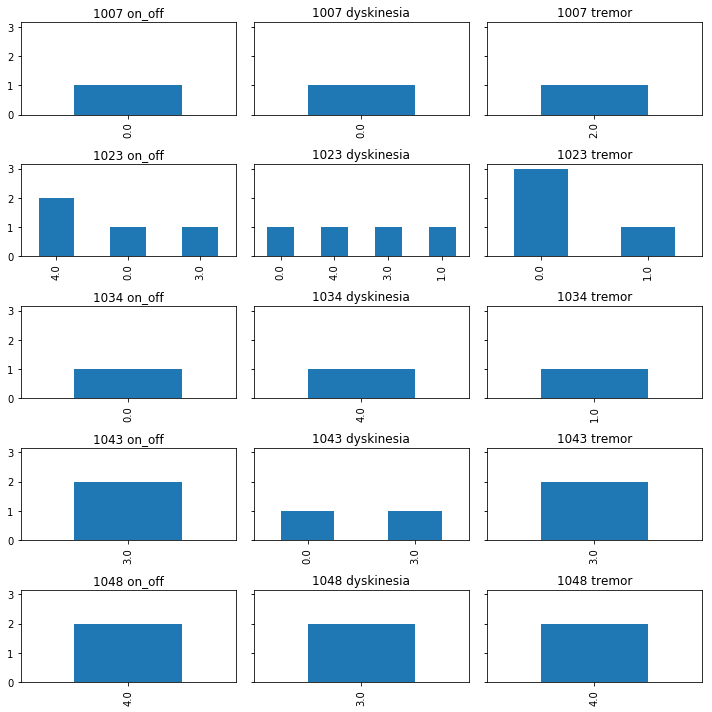

In [10]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

## KFold 

In [55]:
# KFold 
import numpy as np
from sklearn.model_selection import KFold

'''
Function that returns a list of measurement_id in X dataframes (X is according to the number of n_splits chosen)

Arguments:
df_train_label: Dataframe containing the labels
n_split: Optional. The number of folds. Default: 5
subject_id: Optional. Specify a subject_id to get measurement_id only for that subject_id 
'''
def get_k_fold(df_train_label, n_splits=5, subject_id=None):
    kf = KFold(n_splits)
    
    # Building the dataframe to split
    X = []

    #if we want the data split for one specific subject_id
    if subject_id: 
        df_train_label_subject_id = df_train_label.groupby('subject_id')
        X = df_train_label_subject_id.get_group(subject_id)
        
    # if we want to have all a split for all data no matter the subject_id
    # NOTE: I didn't make sure to have one subject_id represented in both train/test
    else: 
        for idx in df_train_label.index: 
            X.append([df_train_label["measurement_id"][idx]])
        X = pd.DataFrame(X)

    kf.get_n_splits(X)

    # Building lists of X_train because we have by default 5 splits, so the lists will contain 5 DataFrames with 
    # different split indices
    X_train_list = list()
    X_test_list = list()
    for train_index, test_index in kf.split(X):
        X_train_list.append(X.iloc[train_index])
        X_test_list.append(X.iloc[test_index])

    return X_train_list, X_test_list 

In [54]:
# List of interesting measurement id we want to look at 
# list_measurement_id=['ab5287f4-8261-47ad-8ff2-22b5fe5d246e',
# 'db2e053a-0fb8-4206-891a-6f079fb14e3a',
# 'ef5b1267-c212-46c5-aab0-4f4437bc6c67',
# '4ec74fb9-7347-435d-83dc-79ad74c3bc49',
# '8e8539ad-8841-476b-b15c-888ce3461989',
# '22b88456-fe8f-4138-af55-be12afca4b81',
# 'ad84583d-e5ae-4926-b077-531a0f7d08a9',
# 'eef56825-940a-4c3e-aebb-60838d60869e',
# 'e0441156-c4b8-467c-8f4f-3b532d594d8f',
# '464ac314-6c4b-4c4a-957c-28a2339150d6']

# Filter df_train_label according to the measurement_id we are most interested in
#df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)


# Define the data type as we have two databases 
data_type='cis'
path_train_data, df_train_label = define_data_type(data_type=data_type)

X_train_list, X_test_list = get_k_fold(df_train_label=df_train_label, subject_id=1004)
display(X_train_list[0])

# Example on how to read data for the first split at index 0 (hardcoded in example)
# for idx in X_train_list[0].index: 
#         df_train_data=pd.read_csv(path_train_data+X_train_list[0]["measurement_id"][idx]+'.csv')
#         display(df_train_data)



,measurement_id,subject_id,on_off,dyskinesia,tremor
17,3cf49c01-0499-4bad-9167-67691711204a,1004,3.0,3.0,3.0
18,ac449a51-1819-4944-b5c3-ef42be404541,1004,3.0,3.0,3.0
19,8b7abdf9-5aad-4edc-9bc4-078e29f134d6,1004,3.0,3.0,3.0
20,6110744d-3f5c-4f2e-9586-f2722352606f,1004,1.0,1.0,1.0
21,68bf2103-4211-45e9-82d7-8b4e713b2e3b,1004,2.0,2.0,2.0
22,e93b52ca-83af-46fb-baad-46c934ab4edf,1004,3.0,3.0,3.0
23,0b5f2f06-e73c-4838-9f4c-d68b909a9356,1004,1.0,1.0,1.0
24,278a1441-2e3a-467d-81c5-143e0298454b,1004,3.0,3.0,3.0
25,18cdf618-e263-4843-9640-f41ad8ff4bde,1004,1.0,1.0,1.0
26,610face1-43e9-4a7c-b1f2-20deba03d587,1004,1.0,1.0,1.0


,Timestamp,X,Y,Z
0,0.000,-0.016357,0.983643,0.221191
1,0.020,-0.018799,0.972900,0.217529
2,0.040,-0.015381,0.973877,0.221191
3,0.060,-0.013428,0.977295,0.218750
4,0.080,-0.014893,0.975830,0.220215
5,0.100,-0.015869,0.983643,0.222656
6,0.120,-0.008057,0.987549,0.227539
7,0.140,-0.012451,0.977295,0.220703
8,0.160,-0.014893,0.979736,0.217773
9,0.180,-0.012451,0.975830,0.222168


,Timestamp,X,Y,Z
0,0.000,0.275879,0.645996,-0.720215
1,0.020,0.265869,0.628174,-0.715332
2,0.040,0.276855,0.628662,-0.701660
3,0.060,0.273193,0.621826,-0.696289
4,0.080,0.283203,0.628662,-0.695557
5,0.100,0.283203,0.641113,-0.704346
6,0.120,0.284668,0.648926,-0.709717
7,0.140,0.279297,0.645020,-0.713379
8,0.160,0.277344,0.640625,-0.717285
9,0.180,0.276367,0.641113,-0.715820


,Timestamp,X,Y,Z
0,0.000,-0.354248,0.082275,-0.906738
1,0.020,-0.345459,0.079834,-0.890381
2,0.040,-0.340820,0.081055,-0.910400
3,0.060,-0.349609,0.092773,-0.936035
4,0.080,-0.350098,0.095703,-0.938965
5,0.100,-0.356689,0.092285,-0.929199
6,0.120,-0.349365,0.091797,-0.913330
7,0.140,-0.351807,0.091309,-0.912354
8,0.160,-0.343262,0.091797,-0.912354
9,0.180,-0.350830,0.086914,-0.910400


,Timestamp,X,Y,Z
0,0.000,-1.508545,0.567627,0.055664
1,0.020,-1.492920,0.521729,0.126953
2,0.040,-1.501221,0.472900,0.168457
3,0.060,-1.466553,0.407959,0.190430
4,0.080,-1.352051,0.364502,0.216797
5,0.100,-1.213623,0.339600,0.210693
6,0.120,-1.085205,0.327637,0.175049
7,0.140,-1.023438,0.329102,0.124023
8,0.160,-0.958252,0.320801,0.132080
9,0.179,-0.873291,0.291016,0.166260


,Timestamp,X,Y,Z
0,0.000,-1.062744,0.021729,0.238281
1,0.020,-1.095215,0.020020,0.248779
2,0.040,-1.104492,0.114746,0.284424
3,0.060,-1.126953,0.171631,0.284912
4,0.080,-1.149902,0.105713,0.282959
5,0.100,-1.147949,0.066895,0.308350
6,0.120,-1.160889,0.148926,0.266113
7,0.140,-1.228027,0.320557,0.186035
8,0.160,-1.273438,0.367432,0.195557
9,0.180,-1.211182,0.265625,0.208496


,Timestamp,X,Y,Z
0,0.000,0.150391,0.916748,0.033203
1,0.020,0.141113,0.901611,0.027832
2,0.040,0.141602,0.895508,0.046387
3,0.060,0.162842,0.897949,0.065186
4,0.080,0.145264,0.858887,0.046875
5,0.100,0.160400,0.875732,0.082031
6,0.120,0.188721,0.879639,0.104736
7,0.140,0.195068,0.894287,0.112305
8,0.160,0.179199,0.917969,0.107910
9,0.180,0.165283,0.958496,0.100342


,Timestamp,X,Y,Z
0,0.000,0.458740,0.318604,-0.817871
1,0.020,0.453613,0.324951,-0.818848
2,0.040,0.448730,0.335693,-0.823730
3,0.060,0.451172,0.345947,-0.829102
4,0.080,0.453613,0.345459,-0.822754
5,0.100,0.456543,0.345947,-0.816162
6,0.120,0.454590,0.334229,-0.818359
7,0.140,0.462646,0.323975,-0.815674
8,0.160,0.460938,0.343994,-0.820068
9,0.180,0.454346,0.364502,-0.810791


,Timestamp,X,Y,Z
0,0.000,0.374756,-0.013428,-0.944092
1,0.019,0.346436,-0.007568,-0.954590
2,0.039,0.378662,-0.025879,-0.917969
3,0.059,0.382324,0.000244,-0.902100
4,0.079,0.346191,0.162842,-0.906006
5,0.099,0.361572,0.051514,-0.943848
6,0.119,0.372070,0.015625,-0.930176
7,0.139,0.388672,0.023438,-0.920654
8,0.159,0.372559,0.043213,-0.893799
9,0.179,0.346680,0.104980,-0.895752


,Timestamp,X,Y,Z
0,0.000,-0.099854,0.264160,-1.011230
1,0.020,-0.117676,0.241943,-0.974609
2,0.040,-0.096436,0.262207,-0.997314
3,0.060,-0.113770,0.305420,-1.024902
4,0.080,-0.137207,0.270752,-0.970703
5,0.100,-0.114258,0.268555,-0.941406
6,0.120,-0.129150,0.295410,-0.935791
7,0.140,-0.106689,0.286865,-0.950195
8,0.160,-0.103516,0.270752,-0.980225
9,0.180,-0.117920,0.232178,-0.925049


,Timestamp,X,Y,Z
0,0.000,-0.032959,0.555664,-0.821289
1,0.020,-0.040283,0.552734,-0.827393
2,0.040,-0.043701,0.547363,-0.832764
3,0.060,-0.052002,0.537109,-0.834961
4,0.080,-0.048584,0.537109,-0.832764
5,0.100,-0.043701,0.543457,-0.824951
6,0.120,-0.035400,0.555664,-0.816895
7,0.140,-0.029541,0.562012,-0.811035
8,0.160,-0.029541,0.573975,-0.813965
9,0.180,-0.034424,0.577393,-0.816895


,Timestamp,X,Y,Z
0,0.000,0.063721,0.986816,0.160400
1,0.020,0.063232,0.985107,0.170410
2,0.040,0.065186,0.979248,0.182129
3,0.060,0.068604,0.971436,0.187500
4,0.080,0.082031,0.964111,0.189209
5,0.100,0.080566,0.968994,0.197510
6,0.120,0.075928,0.979736,0.193115
7,0.140,0.070068,0.983643,0.176270
8,0.160,0.063232,0.982178,0.168701
9,0.180,0.053223,1.003174,0.173584


,Timestamp,X,Y,Z
0,0.000,0.986816,-0.220459,-0.106934
1,0.020,0.960938,-0.217285,-0.104736
2,0.040,0.992188,-0.233643,-0.102051
3,0.060,0.949219,-0.220215,-0.106201
4,0.080,0.998535,-0.221924,-0.100830
5,0.100,0.946777,-0.225098,-0.104492
6,0.120,0.995850,-0.239502,-0.110352
7,0.140,0.943115,-0.219238,-0.107422
8,0.160,0.999268,-0.229248,-0.105957
9,0.180,0.944580,-0.217773,-0.104492


,Timestamp,X,Y,Z
0,0.00,0.351318,0.798340,-0.505615
1,0.02,0.354736,0.792969,-0.506104
2,0.04,0.357178,0.786621,-0.508545
3,0.06,0.353271,0.783203,-0.503174
4,0.08,0.346924,0.774902,-0.494385
5,0.10,0.347900,0.779785,-0.486084
6,0.12,0.363037,0.770264,-0.476074
7,0.14,0.375488,0.773926,-0.479980
8,0.16,0.379883,0.780273,-0.490234
9,0.18,0.377441,0.785156,-0.500977


,Timestamp,X,Y,Z
0,0.000,0.843018,0.198730,-0.508545
1,0.020,0.836182,0.195801,-0.521973
2,0.040,0.839111,0.196777,-0.517578
3,0.060,0.838623,0.188965,-0.510742
4,0.080,0.838135,0.182129,-0.509766
5,0.100,0.840332,0.177246,-0.516113
6,0.120,0.841309,0.194824,-0.520996
7,0.140,0.840820,0.193848,-0.521484
8,0.160,0.839111,0.187012,-0.512695
9,0.180,0.836182,0.176270,-0.505859


,Timestamp,X,Y,Z
0,0.000,-0.594482,-0.075684,-0.784180
1,0.020,-0.594482,-0.079102,-0.782227
2,0.040,-0.596924,-0.081055,-0.783203
3,0.060,-0.598389,-0.077637,-0.782715
4,0.080,-0.591797,-0.081543,-0.786621
5,0.100,-0.592773,-0.080078,-0.787598
6,0.120,-0.588867,-0.077637,-0.784180
7,0.140,-0.593506,-0.076660,-0.783691
8,0.160,-0.594482,-0.076660,-0.783691
9,0.180,-0.599365,-0.078613,-0.784180


,Timestamp,X,Y,Z
0,0.000,-0.042236,1.011475,0.225342
1,0.020,-0.019531,1.029053,0.262451
2,0.040,-0.016357,1.178467,0.256592
3,0.060,-0.096924,1.297607,0.251221
4,0.080,-0.113037,1.323486,0.273926
5,0.100,-0.090088,1.336426,0.242188
6,0.120,-0.100586,1.366455,0.203369
7,0.140,-0.120361,1.351074,0.212891
8,0.160,-0.121826,1.314209,0.245361
9,0.180,-0.139404,1.183838,0.266846


,Timestamp,X,Y,Z
0,0.000,0.912354,-0.220703,-0.370117
1,0.020,0.916748,-0.189209,-0.395020
2,0.040,1.479736,-0.019043,-0.351562
3,0.060,0.957520,-0.195312,-0.449707
4,0.080,0.876709,-0.198730,-0.406250
5,0.100,0.861572,-0.182861,-0.427979
6,0.120,0.884766,-0.208496,-0.408203
7,0.140,0.834717,-0.219482,-0.387695
8,0.160,0.851074,-0.235840,-0.371826
9,0.179,0.854492,-0.237061,-0.374756


,Timestamp,X,Y,Z
0,0.000,-0.154541,0.488281,-0.843018
1,0.020,-0.155518,0.499023,-0.845215
2,0.040,-0.160889,0.478027,-0.839111
3,0.060,-0.134521,0.533936,-0.847900
4,0.080,-0.183838,0.523438,-0.837158
5,0.100,-0.235840,0.460205,-0.858643
6,0.120,-0.139404,0.487061,-0.880127
7,0.140,-0.171143,0.472168,-0.853516
8,0.160,-0.201904,0.492188,-0.857178
9,0.180,-0.137207,0.515869,-0.856934


,Timestamp,X,Y,Z
0,0.00,-0.211670,0.899414,-0.452881
1,0.02,-0.244873,0.936523,-0.282471
2,0.04,-0.293701,1.029541,-0.226562
3,0.06,-0.304199,1.048584,-0.222656
4,0.08,-0.302246,0.992676,-0.280273
5,0.10,-0.321777,0.925293,-0.416016
6,0.12,-0.363037,0.919189,-0.509766
7,0.14,-0.387939,0.796631,-0.490234
8,0.16,-0.425049,0.736816,-0.423096
9,0.18,-0.434326,0.787109,-0.401367


,Timestamp,X,Y,Z
0,0.000,0.225586,0.742188,-0.596436
1,0.020,0.242432,0.754883,-0.613037
2,0.040,0.239990,0.742188,-0.621826
3,0.060,0.232178,0.745117,-0.619141
4,0.080,0.220703,0.755859,-0.611328
5,0.100,0.218506,0.755371,-0.603027
6,0.120,0.221924,0.767578,-0.596436
7,0.140,0.226807,0.770996,-0.593018
8,0.160,0.228271,0.762695,-0.584717
9,0.180,0.216064,0.755127,-0.577393


,Timestamp,X,Y,Z
0,0.000,-0.003174,0.465088,-0.891113
1,0.020,-0.003174,0.452393,-0.879883
2,0.040,-0.010254,0.442871,-0.874512
3,0.060,-0.008789,0.472412,-0.886230
4,0.080,0.002930,0.444824,-0.863037
5,0.100,0.002441,0.478516,-0.895508
6,0.120,0.015869,0.444092,-0.875244
7,0.140,0.008301,0.456299,-0.884766
8,0.160,0.003906,0.453369,-0.897461
9,0.180,0.015381,0.426514,-0.870850


,Timestamp,X,Y,Z
0,0.000,0.122803,0.288574,-0.940674
1,0.020,0.121826,0.291992,-0.938721
2,0.040,0.117188,0.298340,-0.935303
3,0.060,0.112793,0.301758,-0.939209
4,0.080,0.108887,0.303711,-0.934326
5,0.100,0.102783,0.306641,-0.931885
6,0.120,0.104248,0.309082,-0.924561
7,0.140,0.106201,0.319824,-0.926025
8,0.160,0.102783,0.321777,-0.935791
9,0.180,0.099854,0.319336,-0.941650


,Timestamp,X,Y,Z
0,0.000,0.071289,0.995605,-0.111572
1,0.020,0.073242,0.996094,-0.111572
2,0.040,0.070801,0.993652,-0.113525
3,0.060,0.072754,0.993652,-0.111572
4,0.080,0.071289,0.993164,-0.112549
5,0.100,0.070312,0.996094,-0.113525
6,0.120,0.069824,0.993652,-0.112061
7,0.140,0.069336,0.991211,-0.111572
8,0.160,0.070801,0.992676,-0.112061
9,0.180,0.071289,0.994141,-0.113037


,Timestamp,X,Y,Z
0,0.000,0.854980,0.029297,-0.515381
1,0.020,0.851562,0.026367,-0.518311
2,0.040,0.850586,0.026367,-0.525391
3,0.060,0.853027,0.028809,-0.519287
4,0.080,0.851562,0.023926,-0.522949
5,0.100,0.851562,0.030762,-0.523438
6,0.120,0.853027,0.039551,-0.520752
7,0.140,0.852295,0.035645,-0.516357
8,0.160,0.851562,0.026855,-0.518799
9,0.180,0.852051,0.018066,-0.521973


,Timestamp,X,Y,Z
0,0.000,0.005127,0.411377,-0.887695
1,0.020,-0.001221,0.445068,-0.904541
2,0.040,-0.020752,0.429443,-0.896729
3,0.060,-0.000977,0.402100,-0.894287
4,0.080,-0.007812,0.415771,-0.899170
5,0.100,-0.006104,0.377686,-0.854980
6,0.120,-0.005127,0.414551,-0.873047
7,0.140,0.017090,0.447998,-0.947510
8,0.160,-0.003418,0.438477,-0.937988
9,0.180,-0.028076,0.418457,-0.859131


,Timestamp,X,Y,Z
0,0.000,1.057373,-0.150879,-0.321777
1,0.020,0.853271,-0.013428,-0.366211
2,0.040,0.839844,0.030762,-0.408447
3,0.060,0.893066,-0.106445,-0.412842
4,0.080,0.908203,-0.142090,-0.428955
5,0.100,0.864014,-0.107910,-0.445068
6,0.120,0.706055,0.095215,-0.408936
7,0.140,0.939453,-0.032471,-0.383057
8,0.160,0.952637,-0.015381,-0.377930
9,0.180,0.908691,-0.074219,-0.397217


,Timestamp,X,Y,Z
0,0.000,-0.785400,-0.794678,0.325928
1,0.019,-0.694824,-0.968750,0.326172
2,0.038,-0.683838,-0.973877,0.370605
3,0.057,-0.792725,-0.810791,0.342529
4,0.076,-0.900146,-0.651367,0.366455
5,0.096,-0.992920,-0.549561,0.407715
6,0.115,-1.125732,-0.428223,0.449951
7,0.134,-1.671143,0.823486,0.548096
8,0.153,-3.239258,4.112549,0.333252
9,0.172,-2.724609,4.800537,0.155762


,Timestamp,X,Y,Z
0,0.000,0.954346,0.000732,-0.255859
1,0.020,0.983154,0.000977,-0.259521
2,0.040,0.960205,0.011719,-0.269531
3,0.060,0.978027,0.004883,-0.253662
4,0.080,0.972656,0.012695,-0.253418
5,0.100,0.963135,-0.000977,-0.250000
6,0.120,0.986328,0.009766,-0.254150
7,0.140,0.966553,0.005859,-0.252930
8,0.160,0.976562,0.027344,-0.262939
9,0.180,0.960693,0.008301,-0.260742


,Timestamp,X,Y,Z
0,0.00,-0.184570,-0.251709,0.595947
1,0.02,-0.184082,-0.102295,0.605957
2,0.04,-0.316895,0.058838,0.667480
3,0.06,-0.344482,0.215088,0.746826
4,0.08,-0.549561,0.341064,0.946289
5,0.10,-0.533203,0.313477,0.964111
6,0.12,-0.506348,0.186279,1.135010
7,0.14,-1.266846,0.189453,1.033203
8,0.16,-0.718018,0.015137,1.593994
9,0.18,-0.759277,0.147705,1.377197


,Timestamp,X,Y,Z
0,0.000,-1.017822,1.057861,0.020264
1,0.020,-1.212891,0.989258,0.089844
2,0.040,-1.406006,0.983887,0.153320
3,0.060,-1.626709,1.058350,0.177490
4,0.080,-1.930908,1.298340,0.166504
5,0.100,-2.318604,1.455810,0.194092
6,0.120,-2.560059,1.485107,0.404785
7,0.140,-2.432373,1.292480,0.634521
8,0.160,-2.135254,1.257080,0.923340
9,0.180,-1.959229,1.630127,0.988281


,Timestamp,X,Y,Z
0,0.000,0.651611,0.378662,-0.646973
1,0.020,0.655518,0.376221,-0.651855
2,0.040,0.660889,0.385498,-0.649414
3,0.060,0.651611,0.381592,-0.656006
4,0.080,0.647705,0.391846,-0.656982
5,0.100,0.654053,0.383545,-0.651855
6,0.120,0.655518,0.379150,-0.647461
7,0.140,0.655518,0.381592,-0.649902
8,0.160,0.661377,0.374023,-0.640137
9,0.180,0.642334,0.386963,-0.661865


,Timestamp,X,Y,Z
0,0.000,0.106201,0.621094,-0.772949
1,0.020,0.120605,0.616211,-0.770508
2,0.040,0.133301,0.626221,-0.770752
3,0.060,0.133789,0.621826,-0.765869
4,0.080,0.136230,0.620361,-0.764404
5,0.100,0.131836,0.620605,-0.764893
6,0.120,0.134277,0.617920,-0.770752
7,0.140,0.135254,0.617920,-0.771240
8,0.160,0.128906,0.610840,-0.769531
9,0.180,0.126953,0.608887,-0.763672


,Timestamp,X,Y,Z
0,0.000,0.217529,0.935791,-0.169678
1,0.020,0.226807,0.935791,-0.188232
2,0.040,0.232910,0.942871,-0.214355
3,0.060,0.240967,0.939941,-0.222168
4,0.080,0.238037,0.943848,-0.234375
5,0.100,0.234131,0.951904,-0.246826
6,0.120,0.221436,0.967041,-0.272949
7,0.140,0.243652,1.047607,-0.274414
8,0.160,0.311035,1.208984,-0.118896
9,0.180,0.315918,1.252441,0.112061


,Timestamp,X,Y,Z
0,0.000,-0.345703,0.459961,-0.788330
1,0.020,-0.342529,0.457031,-0.791748
2,0.040,-0.342529,0.451172,-0.793213
3,0.060,-0.347900,0.445801,-0.801270
4,0.080,-0.353760,0.442871,-0.800781
5,0.100,-0.358887,0.447266,-0.799316
6,0.120,-0.366699,0.453125,-0.798340
7,0.140,-0.371582,0.446533,-0.791992
8,0.160,-0.373291,0.442627,-0.787109
9,0.180,-0.370605,0.442139,-0.787109


,Timestamp,X,Y,Z
0,0.000,0.853027,-0.425293,-0.302490
1,0.020,0.847656,-0.428467,-0.316406
2,0.040,0.841797,-0.438477,-0.308105
3,0.059,0.860107,-0.420654,-0.308838
4,0.079,0.860107,-0.419189,-0.324707
5,0.099,0.852295,-0.437500,-0.310059
6,0.119,0.835449,-0.437500,-0.318115
7,0.139,0.845215,-0.428711,-0.306641
8,0.159,0.859619,-0.431885,-0.305420
9,0.179,0.850830,-0.428955,-0.328613


,Timestamp,X,Y,Z
0,0.000,0.329102,-0.013184,-0.933105
1,0.019,0.339111,0.002441,-0.941895
2,0.039,0.337158,-0.025391,-0.944336
3,0.058,0.318115,-0.060547,-0.950684
4,0.077,0.304688,-0.070557,-0.917480
5,0.096,0.313477,-0.037354,-0.931396
6,0.116,0.345947,0.006104,-0.930420
7,0.135,0.360840,0.008545,-0.895996
8,0.154,0.323242,-0.017578,-0.919434
9,0.173,0.294434,-0.023193,-0.904541


,Timestamp,X,Y,Z
0,0.000,-0.732178,0.360352,-0.561279
1,0.020,-0.736084,0.358398,-0.558105
2,0.040,-0.735107,0.364258,-0.553955
3,0.060,-0.721191,0.355957,-0.552490
4,0.080,-0.722656,0.346924,-0.551514
5,0.100,-0.718750,0.348633,-0.554932
6,0.120,-0.720215,0.350586,-0.563232
7,0.140,-0.712402,0.358887,-0.563232
8,0.160,-0.713379,0.350586,-0.567139
9,0.180,-0.717041,0.345215,-0.574951


,Timestamp,X,Y,Z
0,0.000,0.773438,0.684814,-0.050537
1,0.020,0.792236,0.685059,-0.059326
2,0.040,0.822754,0.707520,-0.058350
3,0.060,0.740967,0.718018,-0.043457
4,0.080,0.734131,0.682129,-0.034180
5,0.100,0.862793,0.714600,-0.052979
6,0.120,0.754395,0.737793,-0.062012
7,0.140,0.744385,0.711914,-0.029053
8,0.160,0.823975,0.735352,-0.044434
9,0.180,0.752197,0.750000,-0.056885


,Timestamp,X,Y,Z
0,0.000,0.310547,0.431396,-0.860107
1,0.020,0.266602,0.336182,-0.864258
2,0.040,0.220215,0.305176,-0.872803
3,0.060,0.282471,0.362793,-0.896484
4,0.080,0.205078,0.294434,-0.810547
5,0.100,0.163574,0.352539,-0.949951
6,0.120,0.199951,0.384766,-1.018310
7,0.140,0.176270,0.586182,-1.059082
8,0.160,0.000977,0.684814,-0.917969
9,0.180,-0.082764,0.374756,-1.160156


,Timestamp,X,Y,Z
0,0.000,-1.890137,0.285645,0.137207
1,0.019,-2.219971,0.111816,0.264160
2,0.038,-2.321533,-0.001221,0.397949
3,0.057,-2.181885,-0.041504,0.421875
4,0.076,-2.034424,0.097900,0.342041
5,0.096,-1.854492,0.284668,0.260254
6,0.115,-1.600830,0.390381,0.172119
7,0.134,-1.375732,0.453613,0.104248
8,0.153,-1.214600,0.434814,0.068604
9,0.173,-1.076660,0.353271,0.049072


,Timestamp,X,Y,Z
0,0.000,0.857910,0.522705,0.024170
1,0.020,0.850342,0.523926,0.028564
2,0.040,0.858643,0.526611,0.025146
3,0.060,0.862305,0.526123,0.027832
4,0.080,0.861084,0.528076,0.030762
5,0.100,0.858398,0.522705,0.025635
6,0.120,0.859619,0.526611,0.029053
7,0.140,0.864258,0.527588,0.030762
8,0.160,0.871582,0.527344,0.038574
9,0.180,0.862549,0.533203,0.040527


,Timestamp,X,Y,Z
0,0.000,-0.648193,0.503906,0.279297
1,0.020,-0.725586,0.513184,0.252441
2,0.040,-0.723145,0.441162,0.243896
3,0.060,-0.666748,0.443359,0.225830
4,0.080,-0.676514,0.428223,0.218262
5,0.100,-0.704102,0.347900,0.191650
6,0.120,-0.692383,0.302490,0.163574
7,0.140,-0.639404,0.267334,0.119385
8,0.160,-0.603027,0.158691,0.093262
9,0.180,-0.566650,0.155518,0.111816


,Timestamp,X,Y,Z
0,0.000,-0.088135,0.102051,-0.924072
1,0.020,-0.083984,0.077148,-0.953125
2,0.040,-0.058105,0.041992,-1.023193
3,0.060,-0.077393,0.035400,-1.019531
4,0.080,-0.080322,0.040039,-0.946777
5,0.100,-0.048828,0.056641,-0.942627
6,0.120,-0.026367,0.077637,-0.991455
7,0.140,-0.036621,0.049561,-1.047607
8,0.160,-0.046631,0.024902,-1.024170
9,0.180,-0.072754,0.055420,-0.980225


,Timestamp,X,Y,Z
0,0.000,-0.563232,0.819092,0.010742
1,0.020,-0.562988,0.816650,0.007324
2,0.040,-0.559326,0.830078,0.006348
3,0.060,-0.566650,0.826416,0.011230
4,0.080,-0.572998,0.833740,0.009766
5,0.100,-0.570557,0.824707,0.004395
6,0.119,-0.569580,0.812744,0.006348
7,0.139,-0.571045,0.815674,0.007324
8,0.159,-0.570557,0.815186,0.013672
9,0.179,-0.574463,0.814697,0.009033


,Timestamp,X,Y,Z
0,0.000,0.781982,0.413818,-0.480469
1,0.020,0.781006,0.415771,-0.478516
2,0.040,0.782715,0.424072,-0.478516
3,0.060,0.773926,0.413330,-0.480957
4,0.080,0.775879,0.413330,-0.465820
5,0.100,0.784668,0.422607,-0.468262
6,0.120,0.782715,0.424561,-0.476074
7,0.140,0.780518,0.408447,-0.471680
8,0.160,0.784424,0.410400,-0.476074
9,0.180,0.780029,0.394775,-0.469727


,Timestamp,X,Y,Z
0,0.000,0.022705,0.461426,-0.891357
1,0.020,0.014893,0.403320,-0.869629
2,0.039,0.006104,0.392090,-0.859375
3,0.059,0.026367,0.406494,-0.891113
4,0.079,0.024170,0.465332,-0.909668
5,0.099,-0.002930,0.483887,-0.895996
6,0.119,-0.015381,0.384766,-0.867432
7,0.139,0.008789,0.340576,-0.875244
8,0.159,0.023926,0.406006,-0.895020
9,0.179,0.021240,0.492432,-0.935547


,Timestamp,X,Y,Z
0,0.000,0.324951,0.324219,-0.879639
1,0.020,0.322021,0.329102,-0.879639
2,0.040,0.323486,0.324707,-0.878174
3,0.060,0.326416,0.317871,-0.879150
4,0.080,0.329102,0.315918,-0.878906
5,0.100,0.329590,0.318359,-0.880859
6,0.120,0.328613,0.318848,-0.879395
7,0.140,0.330566,0.320312,-0.879395
8,0.160,0.328857,0.318848,-0.876465
9,0.180,0.330078,0.319824,-0.877930


,Timestamp,X,Y,Z
0,0.000,0.424805,-0.893555,-0.124512
1,0.020,0.606689,-0.910889,-0.164551
2,0.040,1.619873,-0.979492,-0.189697
3,0.060,2.145752,-1.109619,-0.288574
4,0.080,0.320557,-0.761719,-0.662842
5,0.100,0.181641,-0.727051,-0.281982
6,0.120,0.896484,-0.840332,-0.229736
7,0.140,0.955566,-0.964111,-0.320557
8,0.160,0.593994,-1.029785,-0.429932
9,0.180,0.441162,-0.795166,-0.454346


,Timestamp,X,Y,Z
0,0.000,-1.261230,-0.366699,0.135742
1,0.019,-1.079834,-0.050781,0.060791
2,0.038,-1.056885,-0.200439,0.125000
3,0.057,-1.054688,0.007812,0.161621
4,0.076,-0.916016,-0.122803,0.179199
5,0.096,-0.856201,-0.018555,0.082764
6,0.115,-0.658447,-0.072021,0.038818
7,0.134,-0.518555,0.028564,0.054932
8,0.153,-0.453369,0.020264,-0.008301
9,0.173,-0.432617,-0.016357,0.026123


,Timestamp,X,Y,Z
0,0.000,0.052979,0.913574,0.280518
1,0.020,0.044189,0.989014,0.273926
2,0.040,0.057373,1.040771,0.285400
3,0.060,0.088623,1.030273,0.279785
4,0.080,0.116211,0.998779,0.321289
5,0.100,0.144043,0.989502,0.353027
6,0.120,0.161133,1.002441,0.400391
7,0.140,0.155273,1.055908,0.488037
8,0.160,0.112793,1.091553,0.541260
9,0.180,0.031738,1.083984,0.541504


,Timestamp,X,Y,Z
0,0.000,0.749756,0.896240,-0.583008
1,0.020,0.710938,0.731201,-0.705811
2,0.040,0.646484,0.621094,-0.669434
3,0.059,0.693604,0.581055,-0.487793
4,0.079,0.735107,0.482178,-0.481689
5,0.099,0.695068,0.410400,-0.432129
6,0.118,0.618408,0.569092,-0.482178
7,0.138,0.516602,0.659424,-0.486328
8,0.158,0.477295,0.467529,-0.366699
9,0.178,0.506836,0.145264,-0.293701


,Timestamp,X,Y,Z
0,0.000,0.141846,0.251953,-0.947998
1,0.020,0.137939,0.250977,-0.950928
2,0.040,0.138916,0.247559,-0.950439
3,0.060,0.139893,0.247559,-0.951416
4,0.080,0.141357,0.243164,-0.949951
5,0.100,0.138916,0.243164,-0.950928
6,0.120,0.136963,0.252441,-0.947510
7,0.140,0.144775,0.255859,-0.945312
8,0.159,0.142090,0.280762,-0.945312
9,0.179,0.135498,0.229004,-0.951416


,Timestamp,X,Y,Z
0,0.000,0.908203,0.363281,-0.298584
1,0.020,0.898438,0.344238,-0.300537
2,0.040,0.923096,0.339355,-0.291504
3,0.060,0.925293,0.375977,-0.272217
4,0.080,0.916504,0.369141,-0.280273
5,0.100,0.904785,0.318604,-0.282471
6,0.119,0.903564,0.295166,-0.281982
7,0.139,0.903076,0.327637,-0.235352
8,0.159,0.911377,0.333252,-0.231201
9,0.179,0.930420,0.303955,-0.248291


,Timestamp,X,Y,Z
0,0.000,0.025879,0.328369,-0.950195
1,0.020,0.016357,0.259277,-0.951172
2,0.040,0.014160,0.268066,-0.942627
3,0.060,0.017090,0.281982,-0.954834
4,0.080,0.017578,0.288818,-0.948975
5,0.100,0.018799,0.271729,-0.956543
6,0.120,0.016602,0.273926,-0.953613
7,0.140,0.022461,0.286377,-0.953857
8,0.160,0.026855,0.286865,-0.947021
9,0.180,0.030762,0.292236,-0.945312


,Timestamp,X,Y,Z
0,0.000,0.669922,1.168701,0.084473
1,0.020,0.667969,1.556152,0.167236
2,0.040,0.584473,1.706787,0.487305
3,0.060,0.459473,1.841553,0.598633
4,0.080,0.344238,2.298340,0.363525
5,0.100,0.360840,2.110596,0.071533
6,0.120,0.472656,1.740967,0.084717
7,0.140,0.420654,1.505615,0.121826
8,0.160,0.299805,1.271240,0.131836
9,0.180,0.228760,1.101807,0.075439


,Timestamp,X,Y,Z
0,0.000,0.699707,0.487305,-0.346436
1,0.020,0.761963,0.522461,-0.393799
2,0.040,0.801514,0.594727,-0.381836
3,0.060,0.791992,0.630859,-0.290527
4,0.080,0.794434,0.625488,-0.311035
5,0.100,0.741699,0.555664,-0.348633
6,0.120,0.740479,0.466064,-0.380859
7,0.140,0.773682,0.500000,-0.363770
8,0.160,0.757812,0.545166,-0.302979
9,0.180,0.769287,0.563721,-0.324219


,Timestamp,X,Y,Z
0,0.000,0.055176,0.915283,0.399658
1,0.020,0.059082,0.916260,0.417236
2,0.040,0.060059,0.915283,0.419189
3,0.060,0.055664,0.917236,0.417725
4,0.080,0.055664,0.914795,0.422119
5,0.100,0.050293,0.911865,0.414795
6,0.119,0.054688,0.915771,0.416260
7,0.140,0.051758,0.915283,0.419678
8,0.159,0.053711,0.918701,0.408936
9,0.179,0.053467,0.915527,0.434082


,Timestamp,X,Y,Z
0,0.000,0.360107,0.760986,-0.454590
1,0.020,0.342773,0.740234,-0.428223
2,0.040,0.292969,0.689453,-0.412598
3,0.060,0.216797,0.697998,-0.433105
4,0.080,0.227783,0.706543,-0.448730
5,0.100,0.270508,0.683594,-0.446777
6,0.120,0.293701,0.683350,-0.442627
7,0.140,0.265381,0.739746,-0.484619
8,0.160,0.230225,0.809326,-0.530762
9,0.180,0.274414,0.848145,-0.516113


,Timestamp,X,Y,Z
0,0.000,-0.121826,0.300781,-0.925781
1,0.020,-0.150146,0.313965,-0.917725
2,0.040,-0.140381,0.351807,-0.934570
3,0.060,-0.144287,0.337891,-0.935791
4,0.080,-0.138916,0.328125,-0.918945
5,0.100,-0.133301,0.311035,-0.917969
6,0.120,-0.122070,0.314941,-0.922363
7,0.140,-0.123535,0.321777,-0.917236
8,0.160,-0.145264,0.340576,-0.946533
9,0.180,-0.131104,0.275879,-0.932861


,Timestamp,X,Y,Z
0,0.000,-0.388184,0.702393,-0.262451
1,0.020,-0.387451,0.708496,-0.317871
2,0.040,-0.396240,0.689209,-0.384521
3,0.060,-0.450684,0.721924,-0.331299
4,0.080,-0.479248,0.720703,-0.292236
5,0.100,-0.484375,0.700684,-0.292480
6,0.120,-0.488770,0.731201,-0.340576
7,0.140,-0.538818,0.778076,-0.355225
8,0.160,-0.615723,0.760010,-0.381592
9,0.180,-0.674072,0.729004,-0.428955


,Timestamp,X,Y,Z
0,0.000,-0.014893,0.480957,-0.931885
1,0.020,-0.057129,0.394043,-0.903320
2,0.040,-0.053467,0.448975,-0.930420
3,0.060,-0.024658,0.463623,-0.877197
4,0.080,-0.037598,0.448975,-0.831543
5,0.100,-0.024658,0.471924,-0.874512
6,0.120,0.027344,0.481201,-0.867676
7,0.140,-0.033936,0.382812,-0.801758
8,0.160,-0.031982,0.448730,-0.866455
9,0.180,-0.017090,0.507812,-0.916260


,Timestamp,X,Y,Z
0,0.000,0.053467,0.651611,-0.750977
1,0.020,0.052490,0.657471,-0.749756
2,0.040,0.052002,0.649170,-0.749023
3,0.060,0.053467,0.651123,-0.751953
4,0.080,0.051025,0.648682,-0.750488
5,0.100,0.049561,0.655029,-0.749023
6,0.120,0.049805,0.657959,-0.749023
7,0.140,0.047852,0.650146,-0.745605
8,0.160,0.048340,0.657959,-0.743896
9,0.180,0.048340,0.656982,-0.743408


,Timestamp,X,Y,Z
0,0.000,-0.166992,0.833496,-0.572510
1,0.020,-0.165771,0.793945,-0.562744
2,0.040,-0.168213,0.777832,-0.570312
3,0.060,-0.176025,0.761475,-0.572266
4,0.080,-0.180908,0.758545,-0.575439
5,0.100,-0.190674,0.750244,-0.572021
6,0.120,-0.195801,0.759521,-0.575439
7,0.140,-0.188965,0.787598,-0.569824
8,0.160,-0.182373,0.824219,-0.563477
9,0.180,-0.163818,0.858643,-0.558105


,Timestamp,X,Y,Z
0,0.000,-0.021240,1.186035,0.478760
1,0.019,-0.060059,1.180664,0.069336
2,0.038,-0.160645,1.167236,-0.141357
3,0.057,-0.245605,1.317139,-0.277832
4,0.077,-0.239746,1.208740,0.132568
5,0.096,-0.138672,0.827148,0.381104
6,0.115,0.110352,0.922363,0.058594
7,0.134,0.208008,1.121094,-0.110840
8,0.153,-0.014648,1.173828,-0.083252
9,0.173,-0.145020,1.097168,0.140625


,Timestamp,X,Y,Z
0,0.000,0.254150,0.375488,-0.885010
1,0.020,0.254639,0.374023,-0.884033
2,0.040,0.255127,0.370117,-0.886475
3,0.060,0.250244,0.361816,-0.885010
4,0.080,0.254639,0.366699,-0.888428
5,0.100,0.248291,0.360352,-0.885498
6,0.120,0.265381,0.385742,-0.880859
7,0.140,0.251953,0.385254,-0.885010
8,0.160,0.257568,0.354492,-0.885498
9,0.180,0.251709,0.369629,-0.887939


# REAL-PD Database

This database, originally named "Parkinson@Home" is renamed to "Real-PD" for this challenge. The study was made over 2 weeks, with at home monitoring. 

The devices used are an android phone, a motorolla watch. 
- `smartwatch_accelerometer` and `smartwatch_gyroscope` : Motorolla Watch
- `smartphone_accelerometer` : Android phone 

-> Question: so is the smartwatch & smartphone accelerometer should measure the same movements? 

The REAL-PD database has many missing values. 

The subject_id `hbv013` is the only one without missing data. Other patients all have at least one missing symptom (`diskenisia`, ) or two (`on/off and tremor`, `on_off and dyskinesia`, `dyskinesia and tremor`) missing.

Measurements id with no data (`on_off`, `dyskinesia` and `tremor` are all missing):
- `b50d1b0c-2cd1-45f8-9097-0742e5cbbcc8`
- `b598c177-4e38-4ea8-8543-bd8f7e580f96`
- `cf841bf8-0082-4ea3-999f-1f43e39a8dc6`
- `b1e15f8a-109f-459b-ba87-46899240ee66`
- `6f0e2580-56ec-4743-9356-d3e4d9a0aee5`
- `773536f6-9b70-43d0-b099-5d167d74924a`
- `54a0e841-ad45-4ba7-ac83-1785c5f7748b`
- `cd9ed2e2-7e04-44c7-b041-7788f133c193`
- `a6954a91-338b-4523-9e4a-5e69a8fac206`

The 3 symptoms are reported as follows in this dataset: 
- `on_off = {0,1}`
  - `Off` : 0 (medication is wearing off) 
  - `On` : 1 (medication is working)
  
- `dyskinesia = {0,1,2}`
  - Without dyskinesia: 0 
  - Non-troublesome dyskinesia: 1 
  - Severe dyskinesia: 2 
  
- `tremor = {0,1,2,3,4}` 
The description of the database mentions `tremor` is rated from 0 to 4 according to its severity, but from all the data, the maximum value of `tremor` recorded is 3. 

Data:
- ancillary
- clinical : UPDRS evaluation score 
- demographics : #TODO


,measurement_id,subject_id,on_off,dyskinesia,tremor
222,5b4c7c81-659d-40ea-a1fd-59622074fd10,hbv023,NaN,NaN,2.0


,t,x,y,z
0,0.000,-7.943961,-4.496311,-0.751779
1,0.001,9.730036,-0.526724,2.858677
2,0.021,-7.795521,-4.438850,-0.780510
3,0.037,9.763555,-0.512359,2.715025
4,0.041,-7.958326,-4.218584,-1.019930
5,0.053,-7.824251,-4.022259,-0.847547
6,0.060,9.591172,-0.526724,2.767697
7,0.080,-7.776367,-3.825934,-0.732626
8,0.081,9.763555,-0.526724,2.834735
9,0.100,9.581595,-0.459687,2.810793


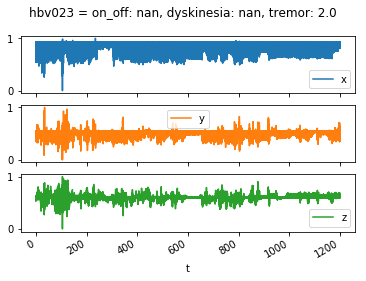

In [57]:
data_type='real' 
#data_real_subtype='smartphone_accelerometer' 
data_real_subtype='smartwatch_accelerometer'
#data_real_subtype='smartwatch_gyroscope'

path_train_data, df_train_label = define_data_type(data_type=data_type)

# List of interesting measurement id we want to look at 
list_measurement_id=['5b4c7c81-659d-40ea-a1fd-59622074fd10']#'ee053d95-c155-400d-ae42-fe24834ad4a9',
# 'ce51ee31-8553-4321-9f83-8cd3dabe2f66',
# 'e07708ff-7b8d-4070-af70-3aa81423ab5b',
# #'7d3f4b7a-167f-4a26-9062-94ce9d8794c1',
# '99af8d14-cd09-4107-9502-355378ba4e08',
# #'7d5ac31a-cb53-40f7-8188-0b13724ea55c',
# '9e43840b-dd89-498b-af1a-a62896a4d5d9',
# 'e391f546-bf8a-46c7-a16c-95bc02f40629']

# Filter df_train_label according to the measurement_id we are most interested in
df_train_label = interesting_patients(df_train_label=df_train_label, list_measurement_id=list_measurement_id)

# Display filtered df_train_label
#display(df_train_label)

###  Plot the accelerometer data 
# Path example: /home/sjoshi/codes/python/BeatPD/code/accelerometer_plots/real/smartwatch_gyroscope/
path = path_save_accelerometer_plots+'/'+data_type+'/'+data_real_subtype+'/'
plot_accelerometer(data_type=data_type, display_df_train_data=True, path_accelerometer_plots=path)


In [12]:
# Compute the occurences of each symptoms for each patient
df_occurences, df_train_label_subject_id = compute_symptoms_occurences_dataframe(df_train_label=df_train_label)

display df occurences


,subject_id,symptom,symptom_value,occurence
0,hbv012,on_off,-1.0,42
1,hbv012,dyskinesia,-1.0,42
2,hbv012,tremor,0.0,29
3,hbv012,tremor,1.0,8
4,hbv012,tremor,2.0,5
5,hbv013,on_off,0.0,43
6,hbv013,on_off,1.0,22
7,hbv013,on_off,-1.0,3
8,hbv013,dyskinesia,0.0,54
9,hbv013,dyskinesia,1.0,11


Nb subject_id :  12


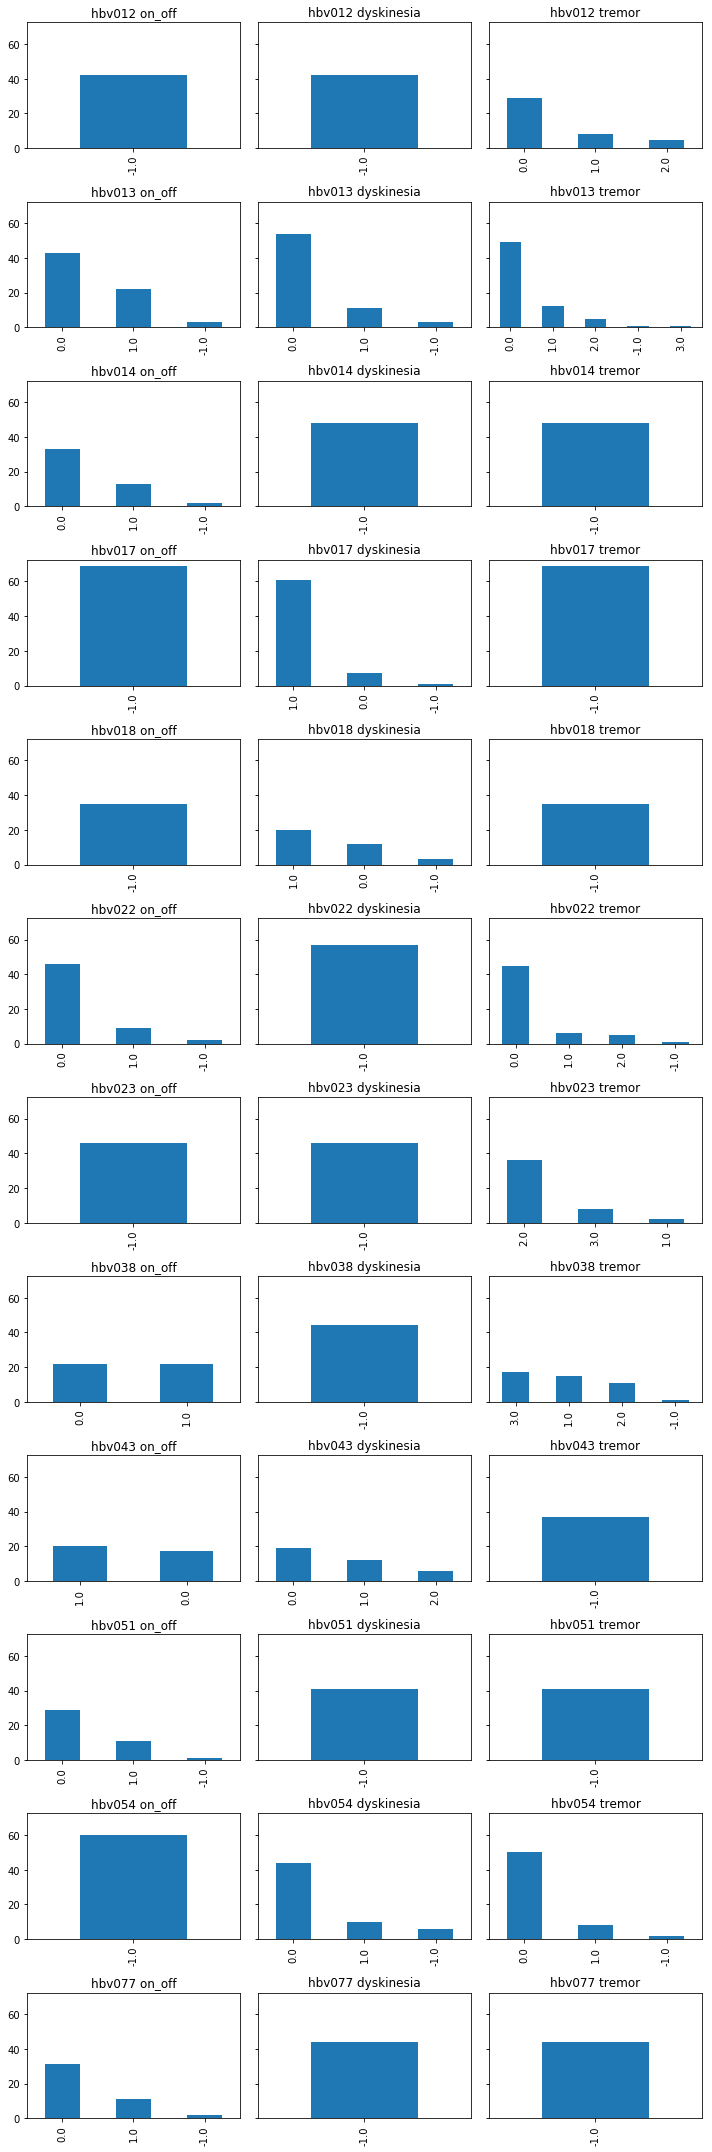

In [13]:
# Plot the graphs 
plot_symptoms_occurences(df_occurences=df_occurences, df_train_label_subject_id=df_train_label_subject_id)

# Comparing both databases


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;border-color:black;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-0pky"></th>
    <th class="tg-0pky">CIS-PD</th>
    <th class="tg-0pky">REAL-PD</th>
  </tr>
  <tr>
    <td class="tg-0pky"># of subject_id training</td>
    <td class="tg-c3ow">16</td>
    <td class="tg-c3ow">12</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of female training</td>
    <td class="tg-c3ow">5</td>
    <td class="tg-c3ow">7</td>
  </tr>
  <tr>
    <td class="tg-0pky"># of male training</td>
    <td class="tg-c3ow">11</td>
    <td class="tg-c3ow">5</td>
  </tr>
  <tr>
    <td class="tg-0pky">Age average (std deviation)</td>
    <td class="tg-c3ow">62.8125 (10.857)</td>
    <td class="tg-c3ow">59.833 (5.828)</td>
  </tr>
</table>



In [59]:
# DataFrame for specified subject_id
#display(df_train_label_subject_id.get_group('hbv013'))

#print(display(df_train_label_subject_id.get_group('hbv013')['tremor'].value_counts()))

# Plots for a specific subject_id the 3 symptoms 
# df_train_label_subject_id.get_group('hbv014')['tremor'].value_counts().plot(kind='bar', title='tremor')
# df_train_label_subject_id.get_group('hbv014')['dyskinesia'].value_counts().plot(kind='bar', title='dys')
# df_train_label_subject_id.get_group('hbv014')['on_off'].value_counts().plot(kind='bar', title='on_off')


# Tests & Drafts, back-up space that's not important, just notes

In [58]:
20*60/59848

0.02005079534821548

### How to filter a DataFrame

In [16]:
# Analysis of the data to find edge cases 


# Create variable with TRUE if nationality is USA
dys = df_train_label['dyskinesia'] > 1

# Create variable with TRUE if age is greater than 50
tre = df_train_label['on_off'] > 0

# Select all cases where nationality is USA and age is greater than 50
df_train_label[dys & tre]

,measurement_id,subject_id,on_off,dyskinesia,tremor
457,ead7c4df-53fc-493e-be19-39e5c269f003,hbv043,1.0,2.0,NaN
458,f71ba377-2f59-4605-ae3f-8221d2120c7f,hbv043,1.0,2.0,NaN
461,6792f751-13bb-475c-9591-a6048f0f7353,hbv043,1.0,2.0,NaN
465,1f8d2c61-70d2-4292-a75a-1e5164460e06,hbv043,1.0,2.0,NaN
472,5e327c6b-de1f-44d8-a1ab-4933df65d94c,hbv043,1.0,2.0,NaN
491,bc419495-0ef5-49d8-bba0-40cab15f38c8,hbv043,1.0,2.0,NaN


### Playing around with pct_change function to try and remove_silence

In [ ]:
cars = {'Brand': ['Honda Civic','Toyota Corolla','Ford Focus','Audi A4','Toyota Corolla','Ford Focus','Audi A4'],
        'Price': [0,1,2,3,4,5,6]
        }

df = pd.DataFrame(cars, columns = ['Brand', 'Price'])
display(df)

display(df['Price'].pct_change(periods=1))

display(df['Price'].pct_change(periods=2))

display(df['Price'].pct_change(periods=5))